# `qubit_discovery` Transmon Optimization

Here, we use `qubit_discovery` to optimize an asymmetric transmon for a specific target frequency $f_{01}^*$, long $T_2$ time, and high anharmonicity. The point of this notebook is to show an entire workflow start-to-end; see the other tutorial notebooks for more details about the different functions used.

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import qubit_discovery as qd
import SQcircuit as sq

1. Initialize a sampler to randomly sample circuits from allowed element ranges.

In [2]:
# Turn on optimization
sq.set_optim_mode(True)

# Construct circuit sampler
sampler = qd.optimization.CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0 + 1e-2, 2 * np.pi - 1e-2]   
)

2. Construct loss function, using some built-in and some custom metrics. We'll optimize for
- A target qubit frequency of 6.5 GHz (custom metric)
- Low sensitivity to external flux and charge
- Long $T_2$ times and large anharmonicity $\mathcal{A}$. This is captured in a metric `'number_of_gates'` $\mathcal{N} = \mathcal{A}T_2$, which represents a bound on the number of single-qubit gates which can be performed.

In [13]:
# Construct a custom metric function for target frequency
TARGET_FREQUENCY = 6.5

def target_freq_loss(circuit):
    circuit_freq = circuit.efreqs[1] - circuit.efreqs[0]

    loss = ((circuit_freq - TARGET_FREQUENCY)/TARGET_FREQUENCY)**2
    return loss, circuit_freq

qd.losses.add_to_metrics('target_frequency', target_freq_loss)


# Build total loss function 
my_loss_function = qd.losses.build_loss_function(
    use_losses = { # setting all weights equal for this example
        'target_frequency': 1.0,
        'number_of_gates': 1.0,
        'charge_sensitivity': 1.0,
        'flux_sensitivity': 1.0
    },
    use_metrics = ['t1', 't_phi'] # interesting to track T1 and T_phi
)

3. Perform the optimization. Because gradient descent can get stuck in local minima, we run optimization 20 times with different random initializations.

In [39]:
optimized_circuits = []
loss_records = []
metric_records = []
print(sampler.bounds)

for i in range(20):
    circuit = sampler.sample_circuit_code('JJ')
    final_circuits, loss_results, metric_results = qd.optimization.run_BFGS(
        circuit = circuit,
        loss_metric_function  = my_loss_function,
        max_iter = 50,
        total_trunc_num = 50,
        bounds = sampler.bounds,
    )

    # The output of the optimization is the optimized circuit and a record
    # of the loss and calculated metrics at each step. We save those
    optimized_circuits.append(final_circuits)
    loss_records.append(loss_results)
    metric_records.append(metric_results)

{<class 'SQcircuit.elements.Capacitor'>: tensor([1.0000e-15, 1.2000e-11]), <class 'SQcircuit.elements.Inductor'>: tensor([1.0000e-15, 5.0000e-06]), <class 'SQcircuit.elements.Junction'>: tensor([6.2832e+09, 6.2832e+11]), <class 'SQcircuit.elements.Loop'>: tensor([0.0100, 6.2732])}
[tensor(1.7843, dtype=torch.float64, requires_grad=True), tensor(4.4928e+11, dtype=torch.float64, requires_grad=True), tensor(4.1625e+10, dtype=torch.float64, requires_grad=True), tensor(1.7360e-15, dtype=torch.float64, requires_grad=True)]
set_trunc_nums called
diag called
diag called
diag called
diag called
diag called
Iteration 0
==================================================Line search called.==================================================
params:tensor([2.0191, 0.5465, 1.7506, 2.6521], requires_grad=True)
p: tensor([ -25.7071,  118.0267,   -2.5175, -246.4347], dtype=torch.float64), alpha: 100
diag called
diag called
diag called
diag called
diag called
diag called
diag called
diag called
diag calle

4. We can now look at the best-performing optimizations. Let's start by plotting the learning curve of some of the runs.

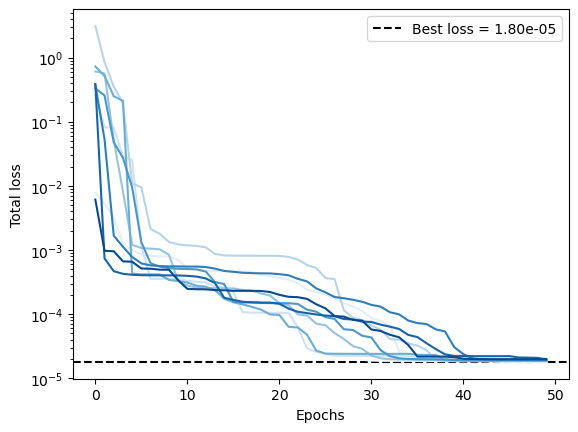

In [50]:
best_runs = sorted(np.arange(len(loss_records)), key = lambda i: loss_records[i]['total_loss'][-1])
loss_records.sort(key = lambda rec: rec['total_loss'][-1])

# Plot best 10 optimizations
norm = matplotlib.colors.Normalize(vmin=0, vmax=10) 
sm = matplotlib.cm.ScalarMappable(cmap=matplotlib.colormaps['Blues'], norm=norm)  
for i, rec in enumerate(loss_records[:10]):
    if i == 0:
        best_loss = rec['total_loss'][-1]
        plt.axhline(best_loss, label=f'Best loss = {best_loss:.2e}', c='k', linestyle='--')
    plt.semilogy(rec['total_loss'], c=sm.to_rgba(i))
    
plt.xlabel('Epochs')
plt.ylabel('Total loss')
plt.legend()

And now look at the details of the best circuit.

In [62]:
best_circuit = optimized_circuits[best_runs[0]]
best_loss_record = loss_records[best_runs[0]]
best_metrics_record = metric_records[best_runs[0]]

best_circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'Qubit frequency')

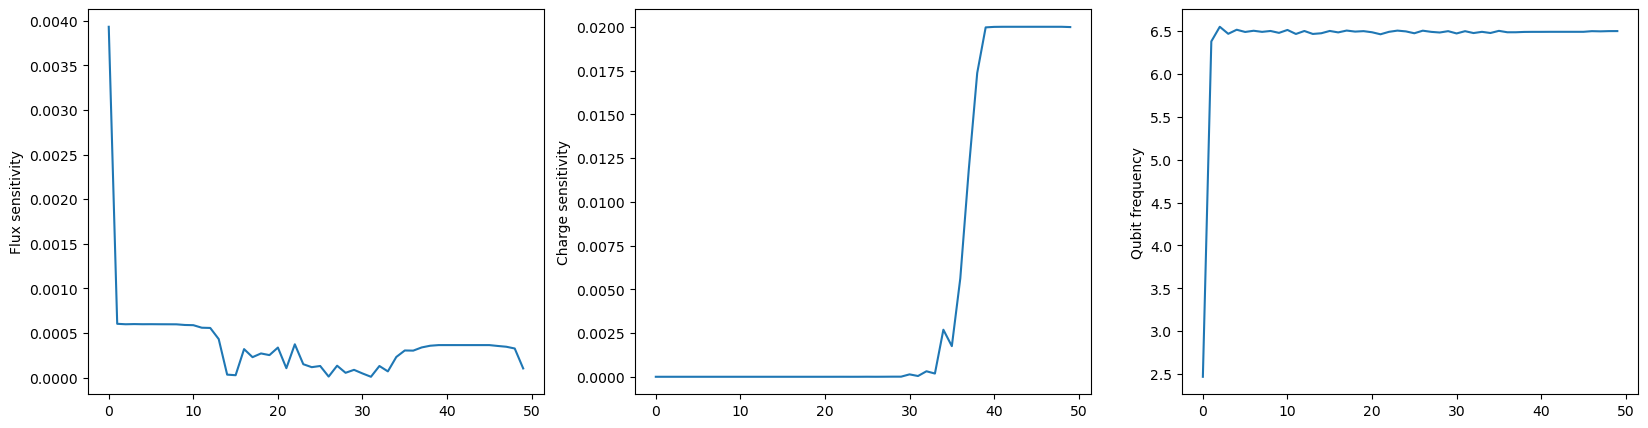

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(best_metrics_record['flux_sensitivity'])
ax[0].set_ylabel('Flux sensitivity')
ax[1].plot(best_metrics_record['charge_sensitivity'])
ax[1].set_ylabel('Charge sensitivity')
ax[2].plot(best_metrics_record['target_frequency'])
ax[2].set_ylabel('Qubit frequency')